In [ ]:
import warnings
import json
import pandas as pd
import torch
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## citation_sentiment_corpus.csv

In [ ]:
raw_df = pd.read_csv('citation_sentiment_corpus.csv')
fig, ax = plt.subplots(figsize=(8,6))
raw_df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(raw_df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

label2id = {'n': 2, 'p': 1, 'o': 0}
raw_df['Sentiment'] = raw_df['Sentiment'].map(label2id)
# pd.DataFrame({'Sentiment':raw_df['Sentiment'], 'Citation_Text':raw_df['Citation_Text']}).to_csv('raw_corpus.csv', index=False)

## controllable-citation-generation

In [ ]:
label2id = {"background": 0, "method": 1, "result": 2}
id2label = {v: k for k, v in label2id.items()}

def read_jsonl(file_path):
    citations = []
    intents = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line.strip())
            citation = entry.get('citation')
            citation_intent = entry.get('citation_intent')
            if citation and citation_intent:
                citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                citations.append(citation)
                intents.append(citation_intent_id)
    return citations, intents

train_citations, train_intents = read_jsonl('controllable-citation-generation/train.jsonl')
test_citations, test_intents = read_jsonl('controllable-citation-generation/test.jsonl')
val_citations, val_intents = read_jsonl('controllable-citation-generation/val.jsonl')
data = train_intents + test_intents + val_intents

label_counts = Counter(data)
labels, counts = zip(*label_counts.items())
labels = [id2label[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

print("Label counts:", dict(zip(labels, counts)))

## citation_sentiment_corpus_balanced.csv

In [ ]:
DATA_PATH = 'citation_sentiment_corpus_balanced.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## corpus.txt

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def count_labels(filepath):
    label_counter = Counter()
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                label_counter[label] += 1
    return label_counter

# Example usage
filepath = 'corpus.txt'
label_counts = count_labels(filepath)

# Plotting the bar chart
labels, counts = zip(*label_counts.items())
label_names = ['Neutral', 'Positive', 'Negative']
label_names = [label_names[label] for label in labels]

plt.bar(label_names, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution in corpus.txt')

# Annotate the counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
import pandas as pd

def txt_to_csv(filepath, output_csv):
    sentences, labels = [], []
    with open(filepath, "r", encoding="utf8") as f:
        file = f.read().split("\n")
        file = [i.split("\t") for i in file]
        for i in file:
            if len(i) == 2:
                sentence = i[1]
                label = int(i[0])
                # Map labels: 2 -> Positive, 1 -> Neutral, 0 -> Negative
                if label == 2:
                    label = 1
                elif label == 1:
                    label = 0
                elif label == 0:
                    label = 2
                sentences.append(sentence)
                labels.append(label)
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame({'Sentiment': labels, 'Citation_Text': sentences})
    df.to_csv(output_csv, index=False)

# Example usage
# txt_to_csv('corpus.txt', 'corpus.csv')
# df = pd.read_csv('corpus.csv')
# df.head(20)

## train_data_aug1.csv

In [ ]:
# df_aug = pd.read_csv('train_data_aug1.csv')
# df_aug.head(20)

## intent_classification_results.csv

In [ ]:
df_intent = pd.read_csv('../output/intent_results/corpus_with_intent.csv')
df_intent

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each intent label
intent_counts = df_intent['intent'].value_counts()

# Plot the distribution of intent labels
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar')
plt.xlabel('Intent Labels')
plt.ylabel('Count')
plt.title('Distribution of Intent Labels')
plt.show()

# Plot the distribution of confidence scores
plt.figure(figsize=(10, 6))
df_intent['confidence'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores')
plt.show()

In [ ]:
# Display rows with the label 'unknown'
unknown_samples = df_intent[df_intent['intent'] == 'unknown']
print("Samples with 'unknown' intent:")
unknown_samples

In [ ]:
# Display rows with confidence score below 0.8
low_confidence_samples = df_intent[df_intent['confidence'] <= 0.6]
print("\nSamples with confidence score below 0.8:")
low_confidence_samples

In [ ]:
from torch.utils.data import DataLoader
from scipy.stats import chi2_contingency
from typing import Tuple, Dict
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
import seaborn as sns

class LabelCorrelationAnalyzer:
    def __init__(self, sentiment_labels: np.ndarray, intent_labels: np.ndarray, sentiment_labelmap: dict, intent_labelmap: dict):
        """
        Initialize the analyzer

        Args:
            sentiment_labels: Array of sentiment labels
            intent_labels: Array of intent labels
            sentiment_labelmap: Dictionary mapping sentiment labels to categories
            intent_labelmap: Dictionary mapping intent labels to categories
        """
        self.sentiment_labels = sentiment_labels
        self.intent_labels = intent_labels
        self.sentiment_labelmap = sentiment_labelmap
        self.intent_labelmap = intent_labelmap
        self.sentiment_classes = np.unique(sentiment_labels)
        self.intent_classes = np.unique(intent_labels)

    def get_contingency_table(self) -> pd.DataFrame:
        """Compute the contingency table"""
        contingency = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='all'  # Compute joint probability distribution
        )
        return contingency

    def chi_square_test(self) -> Tuple[float, float]:
        """Perform chi-square independence test"""
        contingency = pd.crosstab(self.sentiment_labels, self.intent_labels)
        chi2, p_value = chi2_contingency(contingency)[:2]
        return chi2, p_value

    def mutual_information(self) -> Tuple[float, float]:
        """Compute mutual information and normalized mutual information"""
        mi = mutual_info_score(self.sentiment_labels, self.intent_labels)
        nmi = normalized_mutual_info_score(
            self.sentiment_labels,
            self.intent_labels,
            average_method='arithmetic'
        )
        return mi, nmi

    def conditional_probabilities(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Compute conditional probabilities"""
        # P(intent|sentiment)
        p_intent_given_sentiment = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='index'
        )

        # P(sentiment|intent)
        p_sentiment_given_intent = pd.crosstab(
            self.sentiment_labels,
            self.intent_labels,
            normalize='columns'
        )

        return p_intent_given_sentiment, p_sentiment_given_intent

    def plot_heatmap(self, matrix: pd.DataFrame, title: str):
        """Plot heatmap"""
        # Map numerical labels to categories
        matrix.index = [self.sentiment_labelmap[label] for label in matrix.index]
        matrix.columns = [self.intent_labelmap[label] for label in matrix.columns]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            matrix,
            annot=True,
            fmt='.2f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Probability'}
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def analyze_label_correlations(self):
        """Perform full correlation analysis"""
        # 1. Compute and display joint distribution
        joint_dist = self.get_contingency_table()
        print("Joint Distribution:")
        print(joint_dist)
        print("\n")

        # 2. Chi-square test
        chi2, p_value = self.chi_square_test()
        print(f"Chi-square test results:")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")
        print("\n")

        # 3. Mutual information analysis
        mi, nmi = self.mutual_information()
        print(f"Mutual Information Analysis:")
        print(f"Mutual Information: {mi:.4f}")
        print(f"Normalized Mutual Information: {nmi:.4f}")
        print("\n")

        # 4. Conditional probability analysis
        p_intent_given_sentiment, p_sentiment_given_intent = self.conditional_probabilities()

        # 5. Visualization
        self.plot_heatmap(joint_dist, "Joint Distribution of Sentiment and Intent")
        self.plot_heatmap(p_intent_given_sentiment, "P(Intent|Sentiment)")
        self.plot_heatmap(p_sentiment_given_intent, "P(Sentiment|Intent)")

    def get_label_statistics(self) -> Dict:
        """Compute label statistics"""
        stats = {
            'sentiment_distribution': pd.Series(self.sentiment_labels).value_counts().to_dict(),
            'intent_distribution': pd.Series(self.intent_labels).value_counts().to_dict(),
            'total_samples': len(self.sentiment_labels),
            'sentiment_classes': len(self.sentiment_classes),
            'intent_classes': len(self.intent_classes)
        }
        return stats

    @staticmethod
    def from_dataloader(dataloader: DataLoader) -> 'LabelCorrelationAnalyzer':
        """Create analyzer from DataLoader"""
        sentiment_labels = []
        intent_labels = []

        for batch in dataloader:
            sentiment_labels.extend(batch['sentiment_labels'].numpy())
            intent_labels.extend(batch['intent_labels'].numpy())

        return LabelCorrelationAnalyzer(
            np.array(sentiment_labels),
            np.array(intent_labels)
        )


df_intent = df_intent[df_intent['intent'] != 'unknown'] # Remove unknown intent labels
df_intent = df_intent[df_intent['confidence'] > 0.8] # Filter out low confidence scores

sentiment_id2label = {0: 'neutral', 1: 'positive', 2: 'negative'}
intent_id2label = {0: 'background', 1: 'method', 2: 'result'}
intent_label2id = {'background': 0, 'method': 1, 'result': 2}
df_intent['intent'] = df_intent['intent'].map(intent_label2id).astype(int)

sentiment_labels = df_intent['sentiment'].tolist()
intent_labels = df_intent['intent'].tolist()

In [ ]:
# Convert to numpy arrays
sentiment_labels = np.array(sentiment_labels)# 2: negative, 0: neutral, 1: positive
intent_labels = np.array(intent_labels)# 0: background, 1: method, 2: result

# Assuming sentiment_labels and intent_labels are already defined as numpy arrays
analyzer = LabelCorrelationAnalyzer(sentiment_labels, intent_labels, sentiment_id2label, intent_id2label)

# Run full analysis
analyzer.analyze_label_correlations()

# Get label statistics
stats = analyzer.get_label_statistics()
print("Label Statistics:", stats)

## CSA_raw_dataset

In [ ]:
df_neutral = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEUTRAL.csv')
df_negative = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/NEGATIVE.csv')
df_positive = pd.read_csv('CSA_raw_dataset/athar_context_full_derived/POSITIVE.csv')
df_neutral['Sentiment'] = 'Neutral'
df_negative['Sentiment'] = 'Negative'
df_positive['Sentiment'] = 'Positive'

df_neutral.columns = ['Text'] + list(df_neutral.columns[1:])
df_negative.columns = ['Text'] + list(df_negative.columns[1:])
df_positive.columns = ['Text'] + list(df_positive.columns[1:])

df_combined = pd.concat([df_neutral[['Text', 'Sentiment']], df_negative[['Text', 'Sentiment']], df_positive[['Text', 'Sentiment']]], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True) # Shuffle the rows
df_combined.to_csv('CSA_raw_dataset/athar_context_full_derived/combined.csv', index=False)
sentiment_counts = df_combined['Sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
sentiment_counts.plot(kind='bar', ax=ax)
for i, count in enumerate(sentiment_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
df_combined.info()

In [ ]:
df_combined.head()

In [ ]:
df_critical = pd.read_csv('20220206_CORPUS_critical_citations_DATA_PAPER.csv')
df_critical

In [ ]:
def load_negative_text_unrepeated(filepath='../data/20220206_CORPUS_critical_citations_DATA_PAPER.csv'):
    df = pd.read_csv(filepath)
    df = df[df['Source'] != 'Athar_2011']

    return df['Context'].tolist()

negative_texts = load_negative_text_unrepeated()

In [ ]:
# raw_df = pd.read_csv('citation_sentiment_corpus.csv')
# negative_citation_texts = raw_df[raw_df['Sentiment'] == 'n']['Citation_Text'].tolist()
# positive_citation_texts = raw_df[raw_df['Sentiment'] == 'p']['Citation_Text'].tolist()
# neutral_citation_texts = raw_df[raw_df['Sentiment'] == 'o']['Citation_Text'].tolist()

raw_df = pd.read_csv('corpus.csv')
negative_citation_texts = raw_df[raw_df['Sentiment'] == 2]['Citation_Text'].tolist()
positive_citation_texts = raw_df[raw_df['Sentiment'] == 1]['Citation_Text'].tolist()
neutral_citation_texts = raw_df[raw_df['Sentiment'] == 0]['Citation_Text'].tolist()

combined_negative_texts = negative_texts + negative_citation_texts

df_negative = pd.DataFrame({'Text': combined_negative_texts, 'Sentiment': 'Negative'})
df_positive = pd.DataFrame({'Text': positive_citation_texts, 'Sentiment': 'Positive'})
df_neutral = pd.DataFrame({'Text': neutral_citation_texts, 'Sentiment': 'Neutral'})
df_combined = pd.concat([df_neutral[['Text', 'Sentiment']], df_positive[['Text', 'Sentiment']], df_negative[['Text', 'Sentiment']]], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
# df_combined.to_csv('citation_sentiment_corpus_expand.csv', index=False)

df_combined.info()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
df_combined.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df_combined.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()

## check ACOS Verified OUTPUT

In [8]:
import json
from collections import Counter

filepath = '../output/asqp_results_v2/llama405b_llama8b_verified.json'

with open(filepath, 'r', encoding='utf-8') as f:
    data = json.load(f)

CATEGORY2ID = {
    'METHODOLOGY': 0,
    'PERFORMANCE': 1,
    'INNOVATION': 2,
    'APPLICABILITY': 3,
    'LIMITATION': 4
}

pos_neg_samples = []
for item in data:
    if item['overall_sentiment'] in ['positive', 'negative']:
        pos_neg_samples.append({
            'text': item['text'],
            'overall_sentiment': item['overall_sentiment'],
            'quads': item['final_quadruples'] # 加载verified的四元组
        })

aspect_categories = [quad[2] for sample in pos_neg_samples for quad in sample['quads']]
category_counts = Counter(aspect_categories)
invalid_aspect_categories = set(aspect_categories) - set(CATEGORY2ID.keys())

for sample in pos_neg_samples:
    for quad in sample['quads']:
        if quad[2] in invalid_aspect_categories:
            print(f"Text: {sample['text']}")
            print(f"Quad: {quad}")
            print()
        if quad[3] not in ['positive', 'negative']:
            print(f"Text: {sample['text']}")
            print(f"Quad: {quad}")
            print()

In [13]:
# Process the data
for sample in data:
    quads = sample['final_quadruples']
    filtered_quads = [quad for quad in quads if quad[3] in ['positive', 'negative']]
    filtered_quads = [quad for quad in filtered_quads if quad[2] in CATEGORY2ID.keys()]
    if filtered_quads:
        sample['final_quadruples'] = filtered_quads
    else:
        # If all quadruples would be removed, keep the original quadruples
        pass  # Keep the original quadruples

# Save the modified data
with open(filepath, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

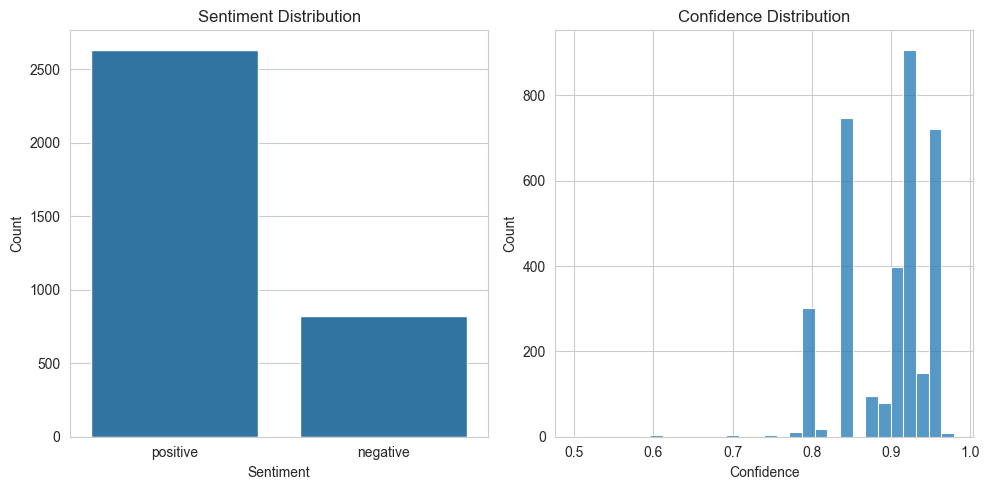


Sentiment Distribution:
positive    2632
negative     822
Name: count, dtype: int64

Confidence Statistics:
Mean confidence: 0.8961
Max confidence: 0.9800
Min confidence: 0.5000


In [15]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sentiments = []
confidences = []
for sample in pos_neg_samples:
    for quad in sample['quads']:
        sentiments.append(quad[3])
        if isinstance(quad[4], float):
            confidences.append(quad[4])


# 创建情感分布图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sentiment_counts = pd.Series(sentiments).value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# 创建置信度分布图
plt.subplot(1, 2, 2)
sns.histplot(confidences, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nConfidence Statistics:")
print(f"Mean confidence: {sum(confidences)/len(confidences):.4f}")
print(f"Max confidence: {max(confidences):.4f}")
print(f"Min confidence: {min(confidences):.4f}")

## check ACOS OUTPUT

In [5]:
import json
from collections import Counter

filepath_neutral = '../output/asqp_results_v2/llama405b.json'

with open(filepath_neutral, 'r', encoding='utf-8') as f:
    data = json.load(f)

neutral_samples = []
for item in data:
    if item['overall_sentiment'] in ['positive', 'negative']:
        neutral_samples.append({
            'text': item['text'],
            'overall_sentiment': item['overall_sentiment'],
            'quads': item['sentiment_quadruples']
        })
        
     
aspect_categories = [quad[2] for sample in neutral_samples for quad in sample['quads']]
category_counts = Counter(aspect_categories)
invalid_aspect_categories = set(aspect_categories) - set(CATEGORY2ID.keys())

for sample in neutral_samples:
    for quad in sample['quads']:
        if quad[4] < 0.7:
            print(f"Text: {sample['text']}")
            print(f"Quad: {quad}")
            print()
        if quad[2] in invalid_aspect_categories:
            print(f"Text: {sample['text']}")
            print(f"Quad: {quad}")
            print()
        # if quad[3] in ['negative']:
        #     print(f"Text: {sample['text']}")
        #     print(f"Quad: {quad}")
        #     print()


Text: The work of Och et al (2004) is perhaps the bestknown study of new features and their impact on translation quality.
Quad: ['impact on translation quality', 'no opinion explicitly mentioned but the overall sentiment is provided as negative', 'PERFORMANCE', 'negative', 0.6]

Text: Work on applying machine learning techniques for automatic citation classification is currently underway (Teufel et al., 2006); the agreement of one annotator and the system is currently K=.57, leaving plenty of room for improvement in comparison with the human annotation results presented here
Quad: ['automatic citation classification', 'currently underway', 'METHODOLOGY', 'positive', 0.6]

Text:   examine the FS of the weighted log-likelihood ratio   on the movie review dataset and achieves an accuracy of 87.1%, which is higher than the result reported by Pang and Lee   with the same dataset.
Quad: ['result', 'reported', 'PERFORMANCE', 'negative', 0.6]

Text: Introduction The creation of the Penn Treeb

In [6]:
# Process the data
for sample in data:
    quads = sample['sentiment_quadruples']
    filtered_quads = [quad for quad in quads if quad[3] in ['positive', 'negative']]
    filtered_quads = [quad for quad in filtered_quads if quad[2] in CATEGORY2ID.keys()]
    if filtered_quads:
        sample['sentiment_quadruples'] = filtered_quads
    else:
        # If all quadruples would be removed, keep the original quadruples
        pass  # Keep the original quadruples

# Save the modified data
with open(filepath_neutral, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

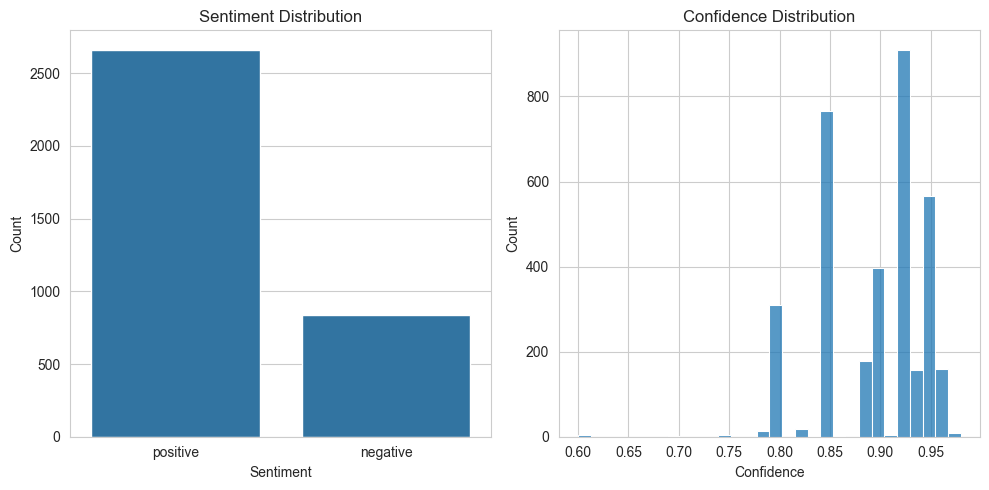


Sentiment Distribution:
positive    2662
negative     836
Name: count, dtype: int64

Confidence Statistics:
Mean confidence: 0.8958
Max confidence: 0.9800
Min confidence: 0.6000


In [7]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sentiments = []
confidences = []
for sample in neutral_samples:
    for quad in sample['quads']:
        sentiments.append(quad[3])
        confidences.append(quad[4])


# 创建情感分布图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sentiment_counts = pd.Series(sentiments).value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# 创建置信度分布图
plt.subplot(1, 2, 2)
sns.histplot(confidences, bins=30)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nConfidence Statistics:")
print(f"Mean confidence: {sum(confidences)/len(confidences):.4f}")
print(f"Max confidence: {max(confidences):.4f}")
print(f"Min confidence: {min(confidences):.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
attention_methods = ['text as query', 'quad as query', 'bidirectional (ours)', 'cascaded']
accuracy_scores = [97.4, 97.7, 98.1, 97.7]  # 示例数据
f1_scores = [94.0, 95.0, 95.7, 94.4]       # 示例数据

def create_comparison_plot(methods, accuracy, f1):
    # 设置全局字体为 Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 18

    # 创建图形和轴
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # 设置柱状图的位置
    x = np.arange(len(methods))
    width = 0.35

    # 定义填充样式
    hatch_patterns = ['/////', '\\\\\\\\\\']  # 斜线填充模式
    colors = ['#1C577C', '#FFB74D']  # 浅蓝色和橙色

    # 绘制柱状图
    rects1 = ax1.bar(x - width/2, accuracy, width, label='Accuracy',
                    color=colors[0], hatch=hatch_patterns[0], edgecolor='black')
    rects2 = ax2.bar(x + width/2, f1, width, label='F1',
                    color=colors[1], hatch=hatch_patterns[1], edgecolor='black')

    # 设置x轴标签
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods)

    # 设置y轴标签
    ax1.set_ylabel('Accuracy(%)')
    ax2.set_ylabel('F1(%)')

    # 设置网格线
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

    # 隐藏右侧Y轴刻度
    ax2.set_yticks([])

    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
              loc='upper right', bbox_to_anchor=(1, 1),
              frameon=True)

    # 设置Y轴范围
    y_min = min(min(accuracy), min(f1)) - 2
    y_max = max(max(accuracy), max(f1)) + 1
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)

    # 调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

# 调用函数创建图表
create_comparison_plot(attention_methods, accuracy_scores, f1_scores)